In [214]:
!echo "ttf-mscorefonts-installer msttcorefonts-eula select true" | sudo debconf-set-selections
!sudo apt-get install msttcorefonts ttf-mscorefonts-installer -y --reinstall
!sudo fc-cache -f
!fc-match "Arial"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'ttf-mscorefonts-installer' instead of 'msttcorefonts'
0 upgraded, 0 newly installed, 1 reinstalled, 0 to remove and 49 not upgraded.
Need to get 24.9 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/multiverse amd64 ttf-mscorefonts-installer all 3.8ubuntu2 [24.9 kB]
Fetched 24.9 kB in 0s (85.0 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
(Reading database ... 124562 files and directories currentl

In [215]:
!pip install seaborn[stats]
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install sklearn
!pip install imblearn
!pip install joblib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [273]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats as stats
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, ShuffleSplit,cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SVMSMOTE
from joblib import dump, load

In [217]:
font_paths = mpl.font_manager.findSystemFonts()
for font_file in font_paths:
  mpl.font_manager.fontManager.addfont(font_file)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.sans-serif'] = 'Arial'

In [218]:
sns.set_theme(style="white", rc={"grid.linewidth": 0.1})
sns.set_style("ticks")
sns.set(font='Arial')
sns.set_context("paper", font_scale=0.9)
plt.figure(figsize=(3.1, 3))
sns.despine(left=False, bottom=False)

<Figure size 310x300 with 0 Axes>

## Reading datasets file turnover and prepared turnover from remote repository

In [219]:


files_paths = ['./drive/MyDrive/dataset_map_tp1/turnover.csv','./drive/MyDrive/dataset_map_tp1/turnover_prepared_1.csv']
datasets = []
for path in files_paths:
  #get csv file encoding
  df = pd.read_csv(path, encoding='Latin-1')

  df.columns = df.columns.str.capitalize()
  datasets.append(df)
print(datasets[1].shape)
datasets[1].head()

(1129, 17)


,Stag,Event,Gender,Age,Industry,Profession,Traffic,Coach,Head_gender,Greywage,Way,Extraversion,Independ,Selfcontrol,Anxiety,Novator,Wayencoded
0,7.030801,1,1,35.0,2,6,4,1,0,1,0,6.2,4.1,5.7,7.1,8.3,0
1,22.965092,1,1,33.0,2,6,2,1,1,1,0,6.2,4.1,5.7,7.1,8.3,0
2,15.934292,1,0,35.0,8,6,4,1,1,1,0,6.2,6.2,2.6,4.8,8.3,0
3,15.934292,1,0,35.0,8,6,4,1,1,1,0,5.4,7.6,4.9,2.5,6.7,0
4,8.410678,1,1,32.0,10,2,7,2,0,1,0,3.0,4.1,8.0,7.1,3.7,0


In [220]:
#Create set of columns name per types
CATEGORY_COLUMNS= ['Industry', 'Profession','Traffic', 'Coach', 'Head_gender','Greywage','Way','Gender']
QUANTITATIVE_COLUMNS = ['Age','Stag','Novator','Anxiety','Selfcontrol','Independ','Extraversion','Wayencoded']
REAL_QUANTITATIVE_COLUMNS = ['Stag', 'Novator','Anxiety','Selfcontrol','Independ','Extraversion']
INTEGER_QUANTITATIVE_COLUMNS = ['Age']
EXPLICATIVES_COLUMNS = CATEGORY_COLUMNS + QUANTITATIVE_COLUMNS
#Target of classification variable
TARGET = 'Event'
COLOR_PALETTE = ['#8B383F','#373D61','#203AE0']

# Track missing values

In [221]:
print(datasets[0].isnull().sum())


Stag            0
Event           0
Gender          0
Age             0
Industry        0
Profession      0
Traffic         0
Coach           0
Head_gender     0
Greywage        0
Way             0
Extraversion    0
Independ        0
Selfcontrol     0
Anxiety         0
Novator         0
dtype: int64


In [222]:
print(datasets[1].isnull().sum())

Stag            0
Event           0
Gender          0
Age             0
Industry        0
Profession      0
Traffic         0
Coach           0
Head_gender     0
Greywage        0
Way             0
Extraversion    0
Independ        0
Selfcontrol     0
Anxiety         0
Novator         0
Wayencoded      0
dtype: int64


# Set of values per categorial features


In [223]:
for column in CATEGORY_COLUMNS:
  print(f'Values of {column} are : ',','.join(datasets[0][column].unique()))


Values of Industry are :  Banks,PowerGeneration,Retail,manufacture,Consult,State,etc,Building,IT, HoReCa,Telecom,Pharma,Mining,transport,Agriculture,RealEstate
Values of Profession are :  HR,Commercial,Marketing,etc,Sales,BusinessDevelopment,Finanñe,Teaching,manage,IT,Law,Consult,Engineer,PR,Accounting
Values of Traffic are :  rabrecNErab,empjs,youjs,referal,advert,KA,recNErab,friends
Values of Coach are :  no,yes,my head
Values of Head_gender are :  f,m
Values of Greywage are :  white,grey
Values of Way are :  bus,car,foot
Values of Gender are :  m,f


In [224]:
def get_description(dataset):
  description = dataset.describe(include='all')
  description = dataset.describe(include='all')
  description.loc['var'] = dataset.var().tolist()
  description.loc['skew'] = dataset.skew().tolist()
  description.loc['kurt'] = dataset.kurtosis().tolist()
  return description
print(get_description(datasets[1]))
stats.normaltest(datasets[1][TARGET])

              Stag        Event       Gender          Age     Industry  \
count  1129.000000  1129.000000  1129.000000  1129.000000  1129.000000   
mean     36.627526     0.505757     0.244464    31.066965     8.614703   
std      34.096597     0.500188     0.429959     6.996147     4.232955   
min       0.394251     0.000000     0.000000    18.000000     0.000000   
25%      11.728953     0.000000     0.000000    26.000000     5.000000   
50%      24.344969     1.000000     0.000000    30.000000    10.000000   
75%      51.318275     1.000000     0.000000    36.000000    12.000000   
max     179.449692     1.000000     1.000000    58.000000    15.000000   
var    1162.577925     0.250188     0.184865    48.946076    17.917904   
skew      1.489674    -0.023061     1.190760     0.660865    -0.282009   
kurt      2.040805    -2.003020    -0.583126     0.069048    -1.194902   

        Profession      Traffic        Coach  Head_gender     Greywage  \
count  1129.000000  1129.000000  1129

NormaltestResult(statistic=4203.106331499798, pvalue=0.0)

In [225]:
data = datasets[1][TARGET].value_counts()

In [226]:
data.values


array([571, 558])

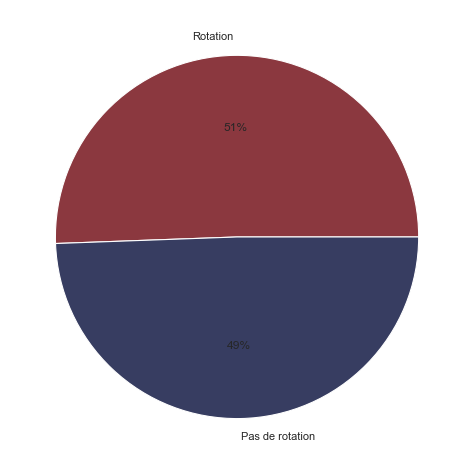

<Figure size 640x480 with 0 Axes>

In [227]:
splot = plt.pie(data, labels=['Rotation', 'Pas de rotation'], colors=COLOR_PALETTE, autopct='%.0f%%')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()
# displaying chart
plt.savefig('pie_chart_rotation.png', bbox_inches='tight')

<ipython-input-228-907bbc6e0c9b>:6: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  splot = sns.displot(


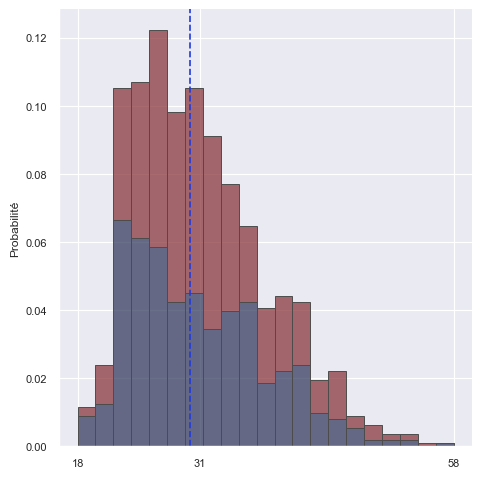

<Figure size 640x480 with 0 Axes>

In [228]:

import matplotlib as mpl



for column in INTEGER_QUANTITATIVE_COLUMNS:
  splot = sns.displot(
      datasets[1],
      x=column, hue=TARGET,
      multiple="stack",
      palette=COLOR_PALETTE,
      edgecolor=".3",
      linewidth=.7,
      stat="probability",
      log_scale=False,
  )

  x_ticks = [int(x) for x in datasets[1][column].unique()]
  splot.ax.set_xticks( [min(x_ticks), int(datasets[1][column].mean()) ,max(x_ticks)])
  plt.axvline(datasets[1][column].median(), color=COLOR_PALETTE[2],linestyle='--', label='Médiane')
  splot.legend.remove()
  splot.ax.set_ylabel("Probabilité")
  splot.ax.set_xlabel("")
  plt.show()
  plt.savefig(f'distribution_{column}.png')

<ipython-input-268-aba66c33c451>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)


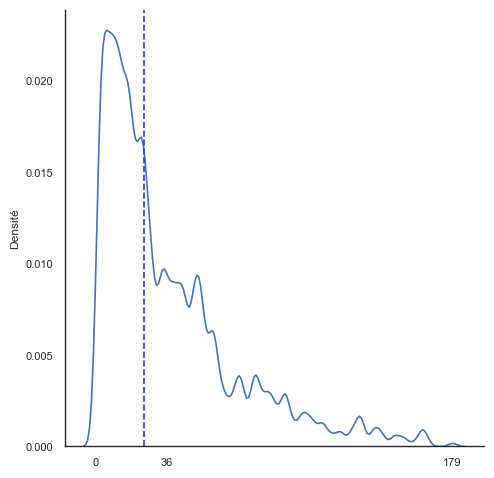

<ipython-input-268-aba66c33c451>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)


<Figure size 640x480 with 0 Axes>

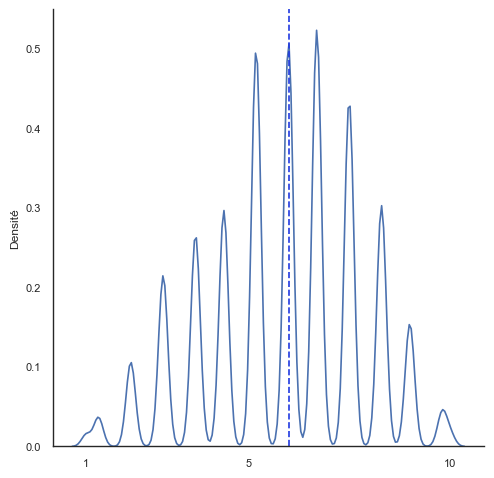

<ipython-input-268-aba66c33c451>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)


<Figure size 640x480 with 0 Axes>

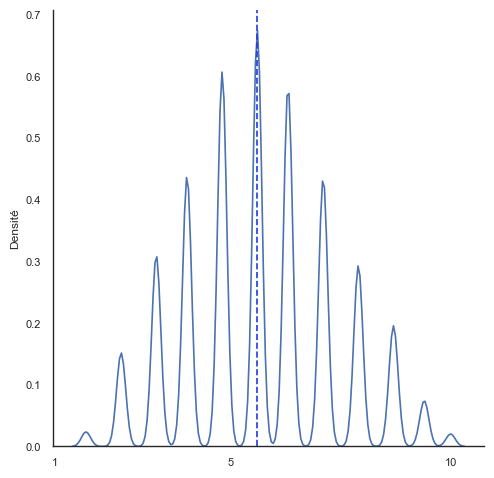

<ipython-input-268-aba66c33c451>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)


<Figure size 640x480 with 0 Axes>

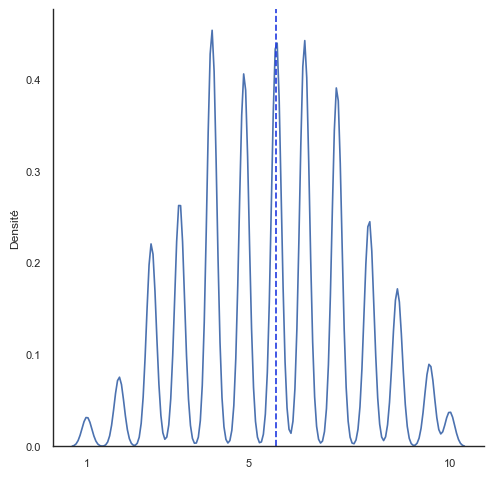

<ipython-input-268-aba66c33c451>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)


<Figure size 640x480 with 0 Axes>

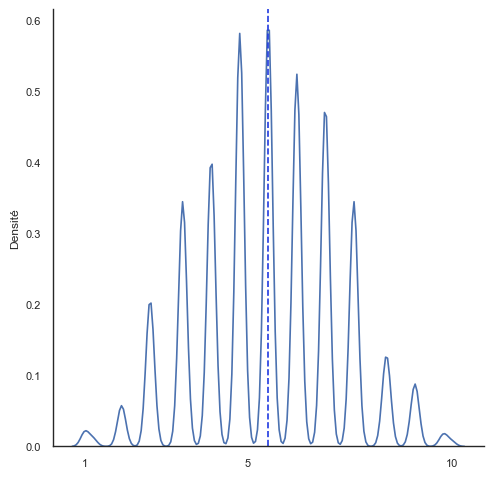

<ipython-input-268-aba66c33c451>:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)


<Figure size 640x480 with 0 Axes>

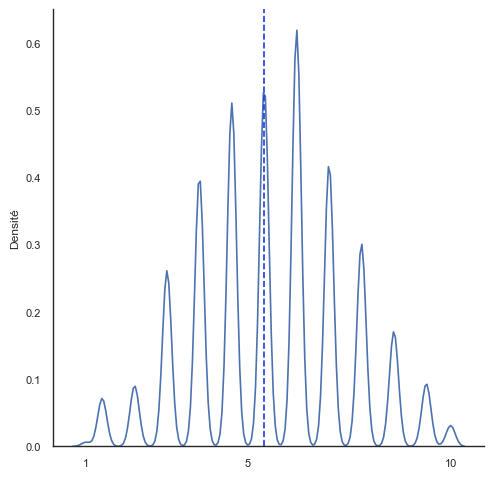

<Figure size 640x480 with 0 Axes>

In [268]:
for column in REAL_QUANTITATIVE_COLUMNS:
  splot = sns.displot(data=datasets[1], x=column, kind="kde",palette=COLOR_PALETTE,  bw_adjust=.25)
  plt.legend().remove()
  x_ticks = [int(x) for x in datasets[1][column].unique()]
  splot.ax.set_xticks( [min(x_ticks), int(datasets[1][column].mean()) ,max(x_ticks)])
  plt.axvline(datasets[1][column].median(), color=COLOR_PALETTE[2],linestyle='--', label='Médiane')
  splot.ax.set_ylabel("Densité")
  splot.ax.set_xlabel("")
  plt.show()
  plt.savefig(f'distribution_{column}.png')

## Outliers detection
To chose best oultliers detection technique we need between IQR , Z-score with manual seuil and Sklearn LocalOutlier

In [270]:
scaler = StandardScaler()
f_scaler = scaler
b = datasets[1].copy()
b[EXPLICATIVES_COLUMNS] = scaler.fit_transform(b[EXPLICATIVES_COLUMNS])

<Axes: >

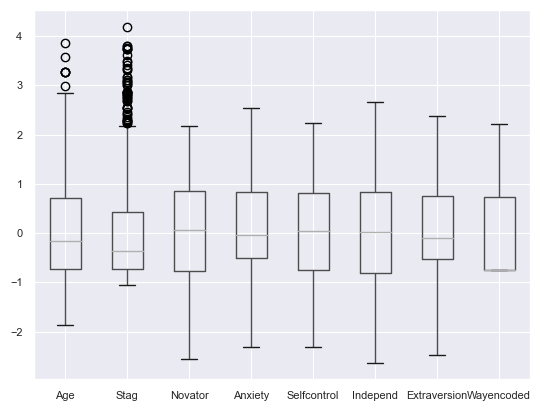

In [231]:
b[QUANTITATIVE_COLUMNS].boxplot()

### Identifying columns that have an outlier

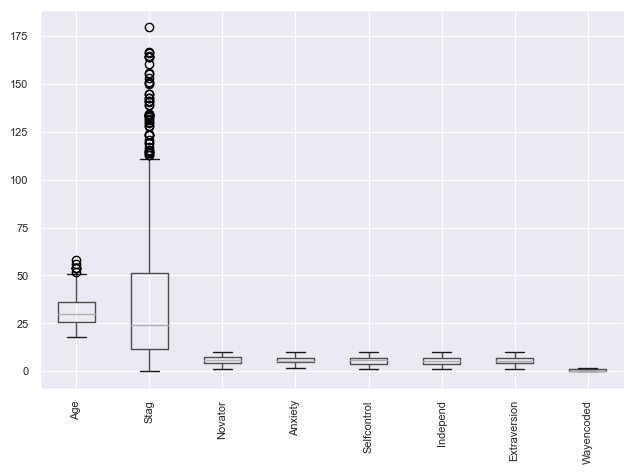

<Figure size 640x480 with 0 Axes>

In [232]:
splot = datasets[1][QUANTITATIVE_COLUMNS].boxplot()
splot.yaxis.grid(True, clip_on=False)
plt.xticks(rotation=90)
plt.tight_layout()
#sns.despine(left=True, bottom=True)
plt.show()
plt.savefig('main_boxplot.png')

### Outliers dedection using IQR

In [233]:
IQR_dataset = b.copy()

IQR of Stag  1.0825604651229708
Upper Bound of Stag: 1.961863397192002
17
Lower Bound of Stag: -2.368378463299881
0
New Shape after removing outliers on column Stag:  (1053, 17)


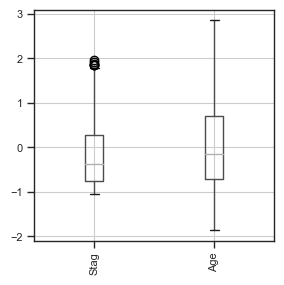

IQR of Age  1.4299915829976453
Upper Bound of Age: 2.8504072896600094
0
Lower Bound of Age: -2.869559042330572
0
New Shape after removing outliers on column Age:  (1053, 17)


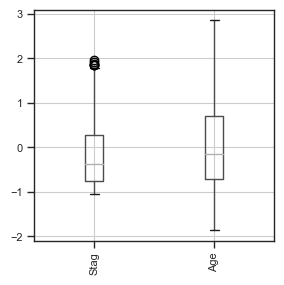

In [259]:
# Columns to remove outlier
columns = ['Stag','Age']
def remove_outliers(IQR_dataset, columns):
  for column in columns:
    # IQR
    Q1 = np.percentile(IQR_dataset[column], 25, method='midpoint')
    Q3 = np.percentile(IQR_dataset[column], 75, method='midpoint')
    IQR = Q3 - Q1
    print(f"IQR of {column} ", IQR)

    # Above Upper bound
    upper = Q3+1.5*IQR
    upper_array = np.array(IQR_dataset[column] >= upper)
    print(f"Upper Bound of {column}:", upper)
    print(upper_array.sum())

    # Below Lower bound
    lower = Q1-1.5*IQR
    lower_array = np.array(IQR_dataset[column] <= lower)
    print(f"Lower Bound of {column}:", lower)
    print(lower_array.sum())


    # Create arrays of Boolean values indicating the outlier rows
    upper_array = np.where(IQR_dataset[column] >= upper)[0]
    lower_array = np.where(IQR_dataset[column] <= lower)[0]

    # Removing the outliers
    IQR_dataset.drop(index=upper_array, inplace=True)
    IQR_dataset.drop(index=lower_array, inplace=True)
    IQR_dataset.reset_index(drop=True, inplace=True)
    # Print the new shape of the DataFrame
    print(f"New Shape after removing outliers on column {column}: ", IQR_dataset.shape)
    IQR_dataset[columns].boxplot(figsize=(3.1, 3))
    plt.xticks(rotation=90)
    #plt.tight_layout()
    plt.show()
  return IQR_dataset
IQR_dataset = remove_outliers(IQR_dataset, columns)
#IQR_dataset = remove_outliers(IQR_dataset, columns)
#IQR_dataset = remove_outliers(IQR_dataset, columns)


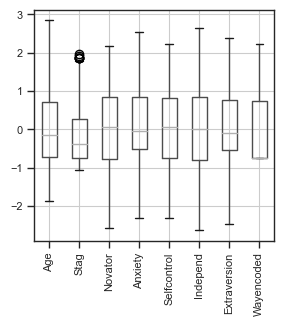

<Figure size 640x480 with 0 Axes>

In [260]:
IQR_dataset[QUANTITATIVE_COLUMNS].boxplot(figsize=(3.1, 3))
plt.xticks(rotation=90)
#plt.tight_layout()
plt.show()
plt.savefig('main_boxplot.png')

In [236]:
IQR_dataset.shape

(1070, 17)

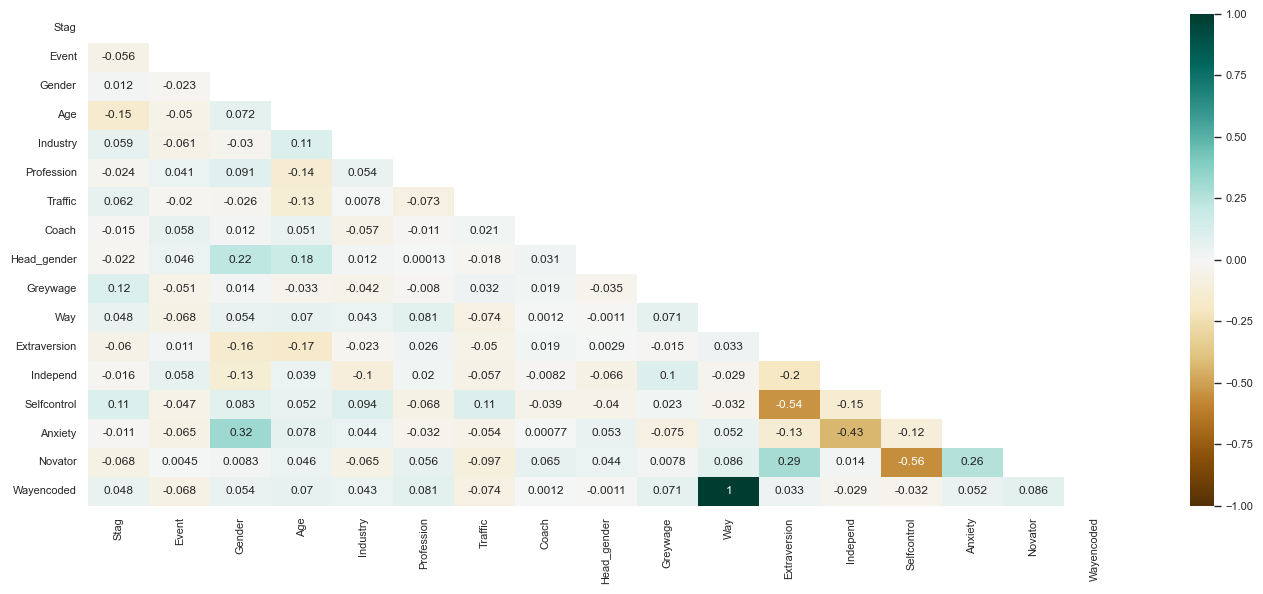

<Figure size 640x480 with 0 Axes>

In [237]:
plt.figure(figsize=(14, 6))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(IQR_dataset.corr()))
heatmap = sns.heatmap(IQR_dataset.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.tight_layout()
plt.box(False)
plt.show()
plt.savefig('main_headmap.png')

### Z-score outliers detection

In [238]:
ZScore_dataset = datasets[1].copy()

<Axes: >

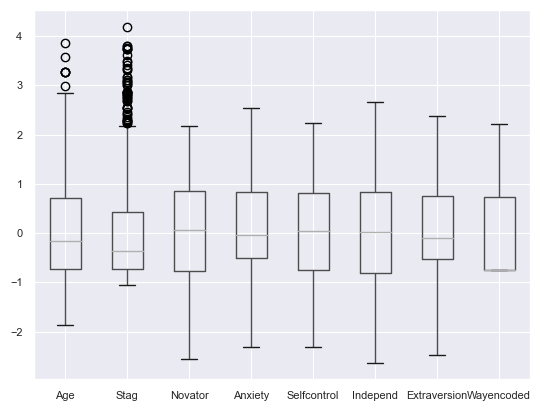

In [239]:





#z-score normalization
scaler = StandardScaler()
ZScore_dataset[EXPLICATIVES_COLUMNS] = scaler.fit_transform(ZScore_dataset[EXPLICATIVES_COLUMNS])
ZScore_dataset[QUANTITATIVE_COLUMNS].boxplot()

In [240]:
age_threshold_z = datasets[1]['Age'].std() * 2.8

In [241]:
outlier_indices = np.where(ZScore_dataset['Stag'] > 2.2)[0]
print(outlier_indices)
no_outliers = ZScore_dataset.drop(outlier_indices)
print("Original DataFrame Shape:", ZScore_dataset.shape)
print("DataFrame Shape after Removing Outliers:", no_outliers.shape)

[   7  108  109  141  148  162  172  197  223  250  254  262  291  327
  328  356  366  374  379  380  394  408  409  509  515  561  568  583
  641  653  674  675  698  709  715  729  749  782  786  899  900  925
  926  960  974  983 1005 1025 1057 1082 1109 1126]
Original DataFrame Shape: (1129, 17)
DataFrame Shape after Removing Outliers: (1077, 17)


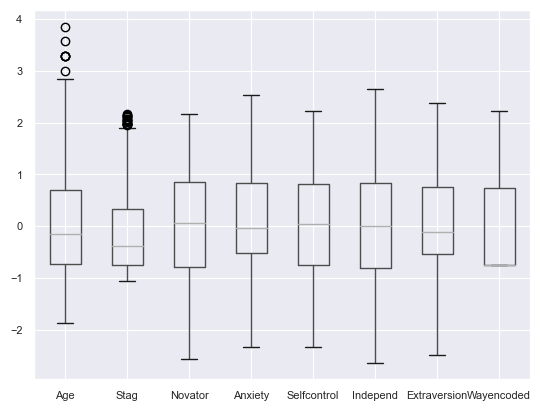

In [242]:
no_outliers[QUANTITATIVE_COLUMNS].boxplot()
no_outliers.reset_index(inplace=True)

In [243]:
threshold_z = 2.8

outlier_indices = np.where(no_outliers['Age'] > threshold_z)[0]
print(outlier_indices, )
no_outliers_2 = no_outliers.drop(outlier_indices)
print("Original DataFrame Shape:", no_outliers.shape)
print("DataFrame Shape after Removing Outliers:", no_outliers_2.shape)

[ 129  131  438  439  610  705  859  881  995 1075]
Original DataFrame Shape: (1077, 18)
DataFrame Shape after Removing Outliers: (1067, 18)


<Axes: >

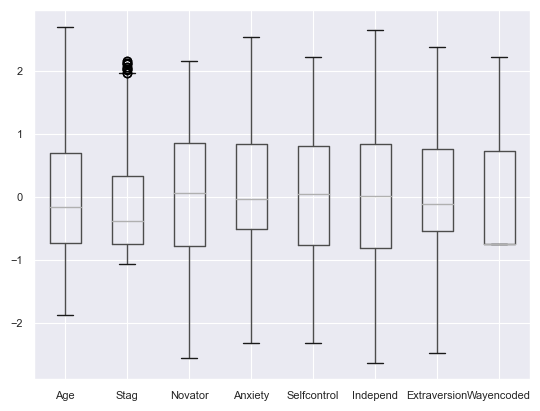

In [244]:
no_outliers_2[QUANTITATIVE_COLUMNS].boxplot()


In [245]:
no_outliers_2.shape

(1067, 18)

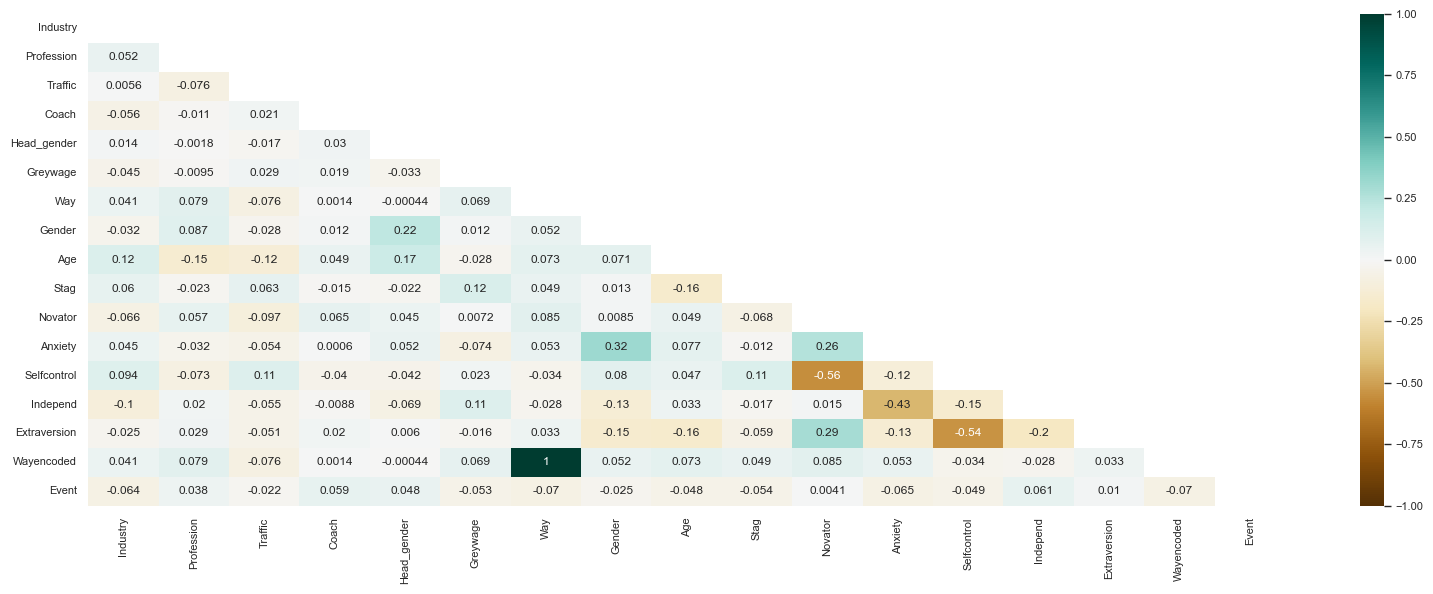

<Figure size 640x480 with 0 Axes>

In [267]:
with sns.axes_style("white"):
  plt.figure(figsize=(16, 6))
  # define the mask to set the values in the upper triangle to True
  mask = np.triu(np.ones_like(no_outliers_2.corr()))
  heatmap = sns.heatmap(no_outliers_2.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
  heatmap.bbox_inches = 'with'
  plt.tight_layout()
  sns.set_style("ticks")
  plt.box(False)
  plt.show()
  plt.savefig('out_main_headmap.png')

### Remove one in paires of coloumns whom have same information

In [247]:
CATEGORY_COLUMNS= ['Industry', 'Profession','Traffic', 'Coach', 'Head_gender','Greywage','Way','Gender']
EXPLICATIVES_COLUMNS = CATEGORY_COLUMNS + QUANTITATIVE_COLUMNS
IQR_dataset = IQR_dataset[EXPLICATIVES_COLUMNS + [TARGET]]
no_outliers_2 = no_outliers_2[EXPLICATIVES_COLUMNS + [TARGET]]
print(IQR_dataset.shape)
print(no_outliers_2.shape)

(1070, 17)
(1067, 17)


In [248]:
ACP_dataset = IQR_dataset.copy()

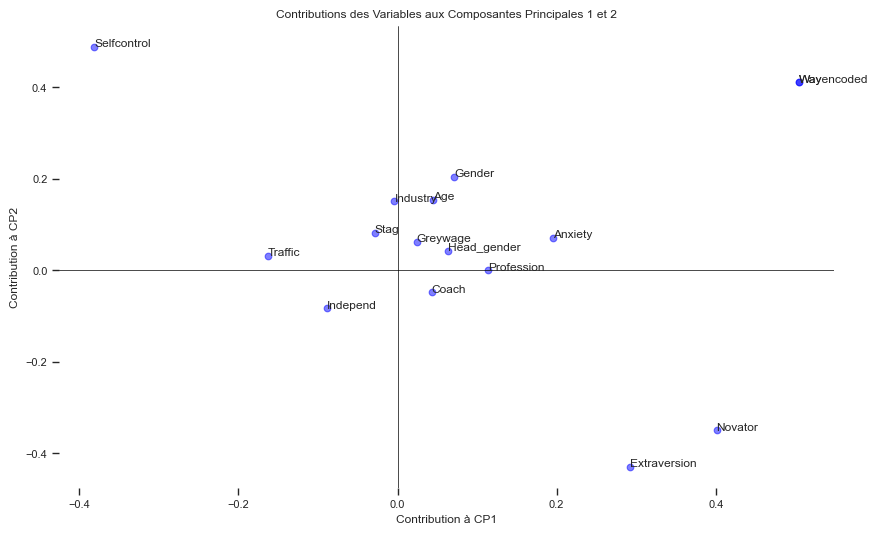

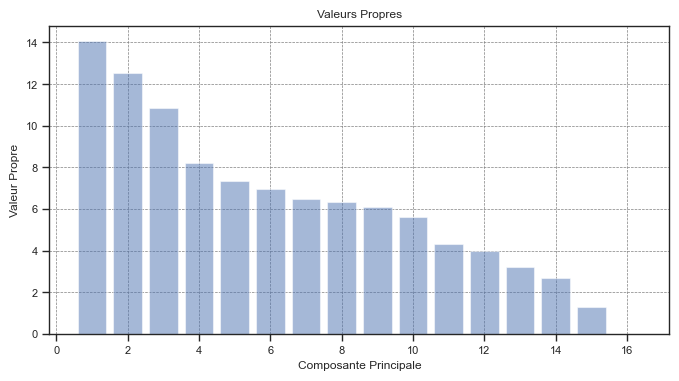

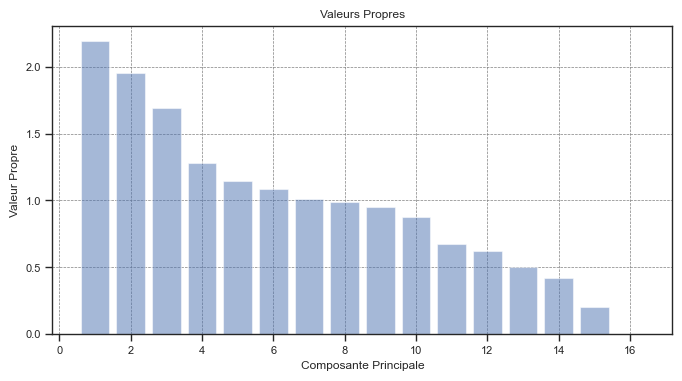

,TVE,PVTE,CumPVTE
C1,2.196609,14.093519,14.093519
C2,1.952162,12.525139,26.618658
C3,1.693432,10.865116,37.483774
C4,1.278433,8.202470,45.686243
C5,1.147038,7.359435,53.045678
C6,1.083687,6.952974,59.998652
C7,1.008658,6.471584,66.470236
C8,0.985013,6.319880,72.790116
C9,0.953686,6.118880,78.908996
C10,0.875124,5.614828,84.523824


In [249]:
def generate_components_short_names(n):
  return [f'C{i+1}' for i in range(n)]

# Créer un objet PCA
pca = PCA(random_state=0)

# Appliquer l'ACP aux données standardisées
pca.fit(ACP_dataset[EXPLICATIVES_COLUMNS])

# Composantes principales
components = pca.components_

# Variance expliquée
explained_variance = pca.explained_variance_ratio_

# Matrice des valeurs propres (Importance des facteurs)
eigenvalues = pca.explained_variance_

# Vecteurs propres (Construction des facteurs)
eigenvectors = pca.components_

# Contributions des variables aux composantes principales 1 et 2
contributions = pca.components_[:2, :].T

# Noms des variables
variable_names = ACP_dataset[EXPLICATIVES_COLUMNS].columns

# Matrice des valeurs propres
# Saturations (Importance des variables / facteurs)
loadings = eigenvectors * np.sqrt(eigenvalues.reshape(-1, 1))

# Créez un graphique de dispersion des contributions
plt.figure(figsize=(10, 6))
plt.scatter(contributions[:, 0], contributions[:, 1], marker='o', color='blue', alpha=0.5)
plt.xlabel('Contribution à CP1')
plt.ylabel('Contribution à CP2')

# Ajoutez les noms des variables
for i, variable in enumerate(variable_names):
    plt.annotate(variable, (contributions[i, 0], contributions[i, 1]))

plt.title('Contributions des Variables aux Composantes Principales 1 et 2')
plt.grid(color='white', linestyle='--', linewidth=0.5)
plt.box(False)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

# Visualisation des valeurs propres
plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigenvalues) + 1), explained_variance *100, alpha=0.5, align='center')
plt.xlabel('Composante Principale')
plt.ylabel('Valeur Propre')
plt.title('Valeurs Propres')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()

plt.figure(figsize=(8, 4))
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues, alpha=0.5, align='center')
plt.xlabel('Composante Principale')
plt.ylabel('Valeur Propre')
plt.title('Valeurs Propres')
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.show()
pd.DataFrame(data = { 'TVE': eigenvalues, 'PVTE': explained_variance*100, 'CumPVTE': np.cumsum(explained_variance*100) },  index=generate_components_short_names(len(eigenvalues)))





In [250]:
from imblearn.over_sampling import SVMSMOTE

In [251]:

#nombre de composantes choisie
n = 7
pca = PCA(n_components=n, random_state=0)
sm = SVMSMOTE(random_state=0)

# Appliquer l'ACP aux données standardisées

reduced_ACP_dataset = pca.fit_transform(ACP_dataset[EXPLICATIVES_COLUMNS])
reduced_ACP_dataset = pd.DataFrame(data=reduced_ACP_dataset, columns=generate_components_short_names(n))
reduced_ACP_dataset[TARGET] = ACP_dataset[TARGET]

# Composantes principales
components = pca.components_

# Corretion du desequilibre
X, y = sm.fit_resample(reduced_ACP_dataset[generate_components_short_names(n)], reduced_ACP_dataset[TARGET])
print(X.shape)
# Diviser le dataset en ensembles d'entraînement et de test
cv = ShuffleSplit(n_splits=500, test_size=0.3, random_state=0)

# Créer un modèle de régression logistique avec régularisation L2 (Ridge)
alpha = 1  # Paramètre de régularisation, ajustez selon vos besoins
model = LogisticRegression( penalty='l2', random_state=0, C=1/alpha, max_iter=1000)

scoring = ['precision_micro', 'roc_auc','recall','accuracy','f1_micro']
# Entraîner le modèle sur les données d'entraînement
scores = cross_validate(model, X, y, cv=cv, scoring=scoring,return_train_score=True, return_estimator=True, return_indices=True)
print(scores.keys(),"%0.2f accuracy with a standard deviation of %0.2f" % (scores['test_accuracy'].mean(), scores['test_roc_auc'].std()))

# Selection du meilleur estimateur (test_recall, test_f1_micro, test_precision_micro, test_accuracy, test_roc_auc)
index = [np.where(scores['test_recall']==scores['test_recall'].max())[0],np.where(scores['test_f1_micro']==scores['test_f1_micro'].max())[0],np.where(scores['test_precision_micro']==scores['test_precision_micro'].max())[0], np.where(scores['test_accuracy']==scores['test_accuracy'].max())[0],np.where(scores['test_roc_auc']==scores['test_roc_auc'].max())[0]]
print(index)









(1084, 7)
dict_keys(['fit_time', 'score_time', 'estimator', 'indices', 'test_precision_micro', 'train_precision_micro', 'test_roc_auc', 'train_roc_auc', 'test_recall', 'train_recall', 'test_accuracy', 'train_accuracy', 'test_f1_micro', 'train_f1_micro']) 0.53 accuracy with a standard deviation of 0.03
[array([135]), array([198]), array([198]), array([198]), array([258])]


In [252]:
Index = np.concatenate(index)
Metrics = ['test_recall', 'test_f1_micro', 'test_precision_micro', 'test_accuracy', 'test_roc_auc']
Performances = {'#Indices': []}
for i in range(len(Metrics)):
  Performances[Metrics[i]] = []
  for j in range(len(Index)):
    Performances[Metrics[i]].append(scores[Metrics[i]][Index[j]])
    Performances['#Indices'].append(Index[j])
es = pd.DataFrame(Performances,columns=Metrics, index=['E1','E2','E3','E4','E5'])
es.columns =  es.columns.str.capitalize()
es.columns =  es.columns.str.replace('_', ' ')
es['#Indice'] = Index
es


,Test recall,Test f1 micro,Test precision micro,Test accuracy,Test roc auc,#Indice
E1,0.767123,0.542945,0.542945,0.542945,0.591248,135
E2,0.634615,0.588957,0.588957,0.588957,0.573039,198
E3,0.634615,0.588957,0.588957,0.588957,0.573039,198
E4,0.634615,0.588957,0.588957,0.588957,0.573039,198
E5,0.553571,0.585890,0.585890,0.585890,0.614791,258


In [253]:
model = scores['estimator'][Index[0]]
X_test = X.iloc[scores['indices']['test'][Index[1]]]
y_test = y.iloc[scores['indices']['test'][Index[1]]]

In [254]:
# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer les métriques de performance
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Afficher les métriques de performance
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", class_report)

Accuracy: 0.549079754601227
Confusion Matrix:
 [[ 65 105]
 [ 42 114]]
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.38      0.47       170
           1       0.52      0.73      0.61       156

    accuracy                           0.55       326
   macro avg       0.56      0.56      0.54       326
weighted avg       0.57      0.55      0.54       326



<Axes: >

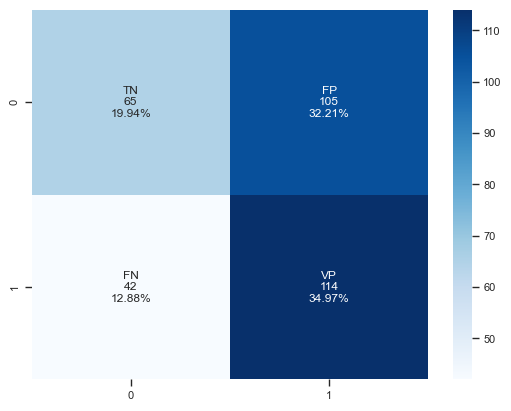

In [255]:
group_names = ['TN','FP','FN','VP']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')

In [275]:
# Sauvegarde des models
dump(model, 'model.joblib')
dump(f_scaler, 'scaler.joblib')
dump(pca, 'pca.joblib')

['pca.joblib']